In [1]:
import pandas as pd
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("VRPEDA").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 12:15:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
# Load the data
delivery_df = spark.read.csv("../data/delivery_cq.csv", header=True, inferSchema=True)
delivery_df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- region_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- courier_id: integer (nullable = true)
 |-- lng: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- aoi_id: integer (nullable = true)
 |-- aoi_type: integer (nullable = true)
 |-- accept_time: string (nullable = true)
 |-- accept_gps_time: string (nullable = true)
 |-- accept_gps_lng: double (nullable = true)
 |-- accept_gps_lat: double (nullable = true)
 |-- delivery_time: string (nullable = true)
 |-- delivery_gps_time: string (nullable = true)
 |-- delivery_gps_lng: double (nullable = true)
 |-- delivery_gps_lat: double (nullable = true)
 |-- ds: integer (nullable = true)



In [23]:
delivery_df.show(5)

+--------+---------+---------+----------+---------+--------+------+--------+--------------+---------------+--------------+--------------+--------------+-----------------+----------------+----------------+----+
|order_id|region_id|     city|courier_id|      lng|     lat|aoi_id|aoi_type|   accept_time|accept_gps_time|accept_gps_lng|accept_gps_lat| delivery_time|delivery_gps_time|delivery_gps_lng|delivery_gps_lat|  ds|
+--------+---------+---------+----------+---------+--------+------+--------+--------------+---------------+--------------+--------------+--------------+-----------------+----------------+----------------+----+
| 2031782|       10|Chongqing|        73|108.71571|30.90228|    50|      14|10-22 10:26:00| 10-22 10:26:00|     108.71826|      30.95587|10-22 17:04:00|   10-22 17:04:00|       108.66361|        30.96702|1022|
| 4285071|       10|Chongqing|      3605|108.71639|30.90269|    50|      14|09-07 10:13:00| 09-07 10:13:00|     108.71791|      30.95635|09-09 15:44:00|   09-09

In [24]:
from functools import reduce
from pyspark.sql.functions import unix_timestamp, col
from pyspark.sql.types import TimestampType

timestamp_cols = ["accept_time", "accept_gps_time", "delivery_time", "delivery_gps_time"]

delivery_df = reduce(lambda df, col_name: df.withColumn(
    col_name, 
    unix_timestamp(col(col_name), "MM-dd HH:mm:ss").cast(TimestampType())
), timestamp_cols, delivery_df)

In [25]:
# List categorical columns and numerical columns
categorical_columns = [c for c, t in delivery_df.dtypes if t == "string"]
numerical_columns = [c for c in delivery_df.columns if c not in categorical_columns]
print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")
delivery_df.printSchema()

Categorical columns: ['city']
Numerical columns: ['order_id', 'region_id', 'courier_id', 'lng', 'lat', 'aoi_id', 'aoi_type', 'accept_time', 'accept_gps_time', 'accept_gps_lng', 'accept_gps_lat', 'delivery_time', 'delivery_gps_time', 'delivery_gps_lng', 'delivery_gps_lat', 'ds']
root
 |-- order_id: integer (nullable = true)
 |-- region_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- courier_id: integer (nullable = true)
 |-- lng: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- aoi_id: integer (nullable = true)
 |-- aoi_type: integer (nullable = true)
 |-- accept_time: timestamp (nullable = true)
 |-- accept_gps_time: timestamp (nullable = true)
 |-- accept_gps_lng: double (nullable = true)
 |-- accept_gps_lat: double (nullable = true)
 |-- delivery_time: timestamp (nullable = true)
 |-- delivery_gps_time: timestamp (nullable = true)
 |-- delivery_gps_lng: double (nullable = true)
 |-- delivery_gps_lat: double (nullable = true)
 |-- ds: integer (nu

In [26]:
# Clean the data
delivery_df = delivery_df.dropna()
delivery_df.show(5)

+--------+---------+---------+----------+---------+--------+------+--------+-------------------+-------------------+--------------+--------------+-------------------+-------------------+----------------+----------------+----+
|order_id|region_id|     city|courier_id|      lng|     lat|aoi_id|aoi_type|        accept_time|    accept_gps_time|accept_gps_lng|accept_gps_lat|      delivery_time|  delivery_gps_time|delivery_gps_lng|delivery_gps_lat|  ds|
+--------+---------+---------+----------+---------+--------+------+--------+-------------------+-------------------+--------------+--------------+-------------------+-------------------+----------------+----------------+----+
| 2031782|       10|Chongqing|        73|108.71571|30.90228|    50|      14|1970-10-22 10:26:00|1970-10-22 10:26:00|     108.71826|      30.95587|1970-10-22 17:04:00|1970-10-22 17:04:00|       108.66361|        30.96702|1022|
| 4285071|       10|Chongqing|      3605|108.71639|30.90269|    50|      14|1970-09-07 10:13:00|

In [27]:
# Show the number of cities
delivery_df.select("city").distinct().show()

+---------+
|     city|
+---------+
|Chongqing|
+---------+



In [28]:
# Show the distribution of accept_time as hour of day
from pyspark.sql.functions import hour
hours = delivery_df.select(hour("accept_time").alias("hour")).groupBy("hour").count().show()
hours

+----+------+
|hour| count|
+----+------+
|  12|  9918|
|  22|   435|
|  13|140357|
|  16| 26013|
|   6|  3139|
|  20|  2700|
|  19|  6048|
|  15| 86394|
|   9| 84761|
|  17| 12515|
|   8|192696|
|  23|   123|
|   7| 37095|
|  10| 16947|
|  21|  1007|
|  11| 10958|
|  14|291968|
|  18|  8235|
|   5|    40|
|   4|     2|
+----+------+



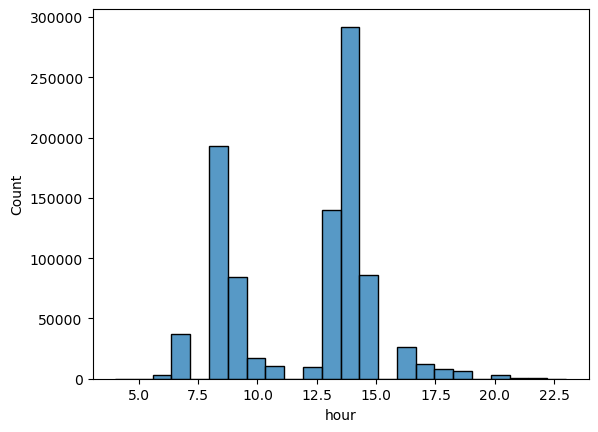

In [29]:
# Plot the distribution of accept_time as hour of day
import matplotlib.pyplot as plt
import seaborn as sns

hours_df = delivery_df.select(hour("accept_time").alias("hour")).toPandas()
sns.histplot(hours_df["hour"], bins=24)
plt.show()

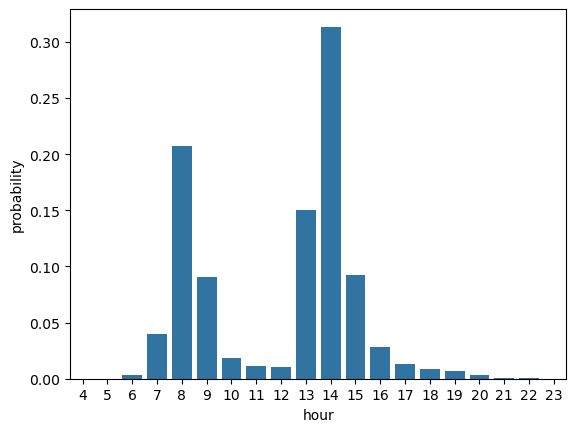

In [30]:
# Convert to probability distribution
hours_df = hours_df["hour"].value_counts(normalize=True).reset_index()
hours_df.columns = ["hour", "probability"]
sns.barplot(x="hour", y="probability", data=hours_df)
plt.show()

In [ ]:
# Load pickup data
pickup_df = spark.read.csv("../data/pickup_sh.csv", header=True, inferSchema=True)
pickup_df.printSchema()
pickup_df.show(5)

root
 |-- order_id: integer (nullable = true)
 |-- region_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- courier_id: integer (nullable = true)
 |-- accept_time: string (nullable = true)
 |-- time_window_start: string (nullable = true)
 |-- time_window_end: string (nullable = true)
 |-- lng: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- aoi_id: integer (nullable = true)
 |-- aoi_type: integer (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- pickup_gps_time: string (nullable = true)
 |-- pickup_gps_lng: double (nullable = true)
 |-- pickup_gps_lat: double (nullable = true)
 |-- accept_gps_time: string (nullable = true)
 |-- accept_gps_lng: double (nullable = true)
 |-- accept_gps_lat: double (nullable = true)
 |-- ds: integer (nullable = true)

+--------+---------+--------+----------+--------------+-----------------+---------------+---------+--------+------+--------+--------------+---------------+--------------+--------------+--

In [65]:
# Drop na
pickup_df = pickup_df.dropna()

In [66]:
from functools import reduce
from pyspark.sql.functions import unix_timestamp, col
from pyspark.sql.types import TimestampType

timestamp_cols = ["accept_time", "time_window_start", "time_window_end", "pickup_time", "pickup_gps_time"]

pickup_df = reduce(lambda df, col_name: df.withColumn(
    col_name, 
    unix_timestamp(col(col_name), "MM-dd HH:mm:ss").cast(TimestampType())
), timestamp_cols, pickup_df)

In [67]:
pickup_df.printSchema()
pickup_df.show(5)

root
 |-- order_id: integer (nullable = true)
 |-- region_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- courier_id: integer (nullable = true)
 |-- accept_time: timestamp (nullable = true)
 |-- time_window_start: timestamp (nullable = true)
 |-- time_window_end: timestamp (nullable = true)
 |-- lng: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- aoi_id: integer (nullable = true)
 |-- aoi_type: integer (nullable = true)
 |-- pickup_time: timestamp (nullable = true)
 |-- pickup_gps_time: timestamp (nullable = true)
 |-- pickup_gps_lng: double (nullable = true)
 |-- pickup_gps_lat: double (nullable = true)
 |-- accept_gps_time: string (nullable = true)
 |-- accept_gps_lng: double (nullable = true)
 |-- accept_gps_lat: double (nullable = true)
 |-- ds: integer (nullable = true)

+--------+---------+--------+----------+-------------------+-------------------+-------------------+---------+--------+------+--------+-------------------+-----------------

In [ ]:
# Show the distribution of accept_time as hour of day
pk_hours = pickup_df.select(hour("accept_time").alias("hour")).groupBy("hour").count()

pk_hours.show()
# Convert to Pandas DataFrame
pk_hours_df = pk_hours.toPandas()

+----+------+
|hour| count|
+----+------+
|  12| 59574|
|  13| 58415|
|  16| 53309|
|  15| 53221|
|   9|154008|
|  17|  1216|
|   8|265406|
|   7|104836|
|  10| 78316|
|  11| 58166|
|  14| 57892|
|  19|    36|
|  18|   118|
|  20|     9|
|  21|     2|
+----+------+



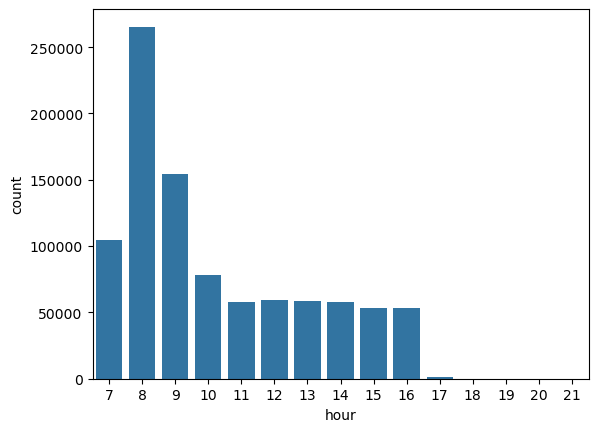

In [69]:
sns.barplot(x="hour", y="count", data=pk_hours_df)
plt.show()

In [70]:
# Save the distribution of accept_time as hour of day, order by hour
pk_hours_df = pk_hours_df.sort_values("hour")
pk_hours_df.to_csv("../output/pickup_hours.csv", index=False)

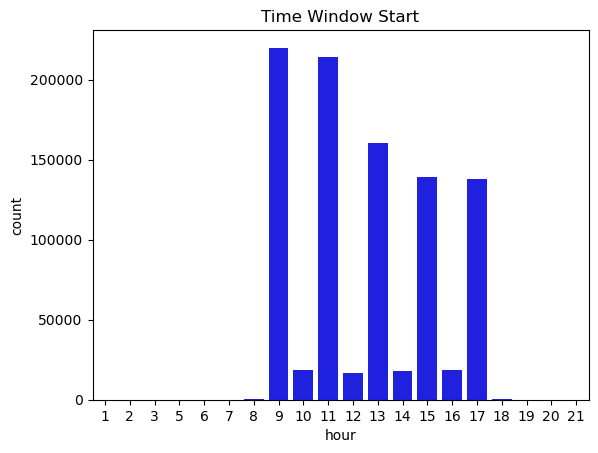

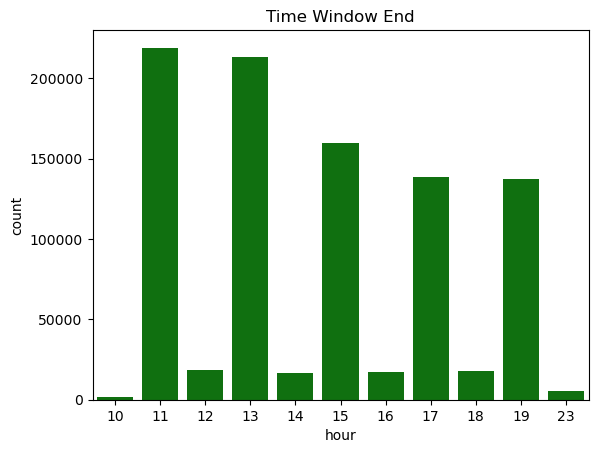

In [71]:
# Show the distribution of time_window_start and time_window_end as hour of day
pk_hours_start = pickup_df.select(hour("time_window_start").alias("hour")).groupBy("hour").count()
pk_hours_end = pickup_df.select(hour("time_window_end").alias("hour")).groupBy("hour").count()
# Convert to Pandas DataFrame
pk_hours_start_df = pk_hours_start.toPandas()
pk_hours_end_df = pk_hours_end.toPandas()

sns.barplot(x="hour", y="count", data=pk_hours_start_df, color='blue')
plt.title("Time Window Start")
plt.show()

sns.barplot(x="hour", y="count", data=pk_hours_end_df, color='green')
plt.title("Time Window End")
plt.show()